<a href="https://colab.research.google.com/github/whaldsz/deep-learning/blob/main/Disease_Indicators_Prediction_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Disease Prediction



## Setup and initialization

In [11]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow import math

from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from keras.utils.vis_utils import plot_model
import os

!pip install -q git+https://github.com/tensorflow/docs 


import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

print("TensorFlow version::", tf.__version__)


from sklearn.model_selection import train_test_split

TensorFlow version:: 2.9.2


In [12]:
from  IPython import display
from matplotlib import pyplot as plt

import numpy as np

import pathlib
import shutil
import tempfile

In [13]:
# currentdir
logdir = os.path.join(os.getcwd(), "tensorboard_logs")
shutil.rmtree(logdir, ignore_errors=True)

In [14]:
# set random seed

tf.random.set_seed(74)

## 1. Dataset Preparation

In [15]:
disease_training = pd.read_csv('https://raw.githubusercontent.com/whaldsz/deep-learning/main/Disease_Prediction/Training.csv')
disease_testing = pd.read_csv('https://raw.githubusercontent.com/whaldsz/deep-learning/main/Disease_Prediction/Testing.csv')
disease_training.head()

,itching,skin_rash,nodal_skin_eruptions,continuous_sneezing,shivering,chills,joint_pain,stomach_pain,acidity,ulcers_on_tongue,...,scurring,skin_peeling,silver_like_dusting,small_dents_in_nails,inflammatory_nails,blister,red_sore_around_nose,yellow_crust_ooze,prognosis,Unnamed: 133
0,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Fungal infection,NaN
1,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Fungal infection,NaN
2,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Fungal infection,NaN
3,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Fungal infection,NaN
4,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Fungal infection,NaN


In [16]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#3 Remove last column

In [17]:
disease_training.isna().sum()

itching                    0
skin_rash                  0
nodal_skin_eruptions       0
continuous_sneezing        0
shivering                  0
                        ... 
blister                    0
red_sore_around_nose       0
yellow_crust_ooze          0
prognosis                  0
Unnamed: 133            4920
Length: 134, dtype: int64

In [18]:
disease_training.drop('Unnamed: 133', inplace=True, axis=1)

disease_training.isna().sum()

itching                 0
skin_rash               0
nodal_skin_eruptions    0
continuous_sneezing     0
shivering               0
                       ..
inflammatory_nails      0
blister                 0
red_sore_around_nose    0
yellow_crust_ooze       0
prognosis               0
Length: 133, dtype: int64

In [19]:
#disease_training.head()

## Convert category to numeric values

In [20]:
#get class labels

class_names = np.unique(disease_training.prognosis)
disease_training.prognosis = pd.Categorical(disease_training.prognosis)
disease_testing.prognosis = pd.Categorical(disease_testing.prognosis)
class_names.shape

(41,)

In [21]:
#disease_training.prognosis.cat.codes
#disease_training
#disease_testing.head()

## Separate Features and Label - Training

### Training Set

In [22]:
X = disease_training.drop('prognosis', axis=1)
y = disease_training.prognosis.cat.codes
np.unique(y)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40], dtype=int8)

### Unseen Test Set

In [23]:
X_unseen = disease_testing.drop('prognosis', axis=1)
y_unseen = disease_testing.prognosis.cat.codes
np.unique(X_unseen)

array([0, 1])

## Split into Training & Validation Test

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=74)
#print(X_train.shape)
#print(y_train.shape)
#print(X_test.shape)
#print(y_test.shape)


In [25]:
X_test

,itching,skin_rash,nodal_skin_eruptions,continuous_sneezing,shivering,chills,joint_pain,stomach_pain,acidity,ulcers_on_tongue,...,pus_filled_pimples,blackheads,scurring,skin_peeling,silver_like_dusting,small_dents_in_nails,inflammatory_nails,blister,red_sore_around_nose,yellow_crust_ooze
4007,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1938,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4462,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3227,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3889,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3741,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3280,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3687,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
# Number of features
FEATURES = X_test.shape[1]
FEATURES

132

## 2. Model Training

### Training configuration

In [27]:
N_VALIDATION = int(1e3)
N_TRAIN = int(1e4)
BUFFER_SIZE = int(1e4)
BATCH_SIZE = 500
STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE

### Create Model

### Find the ideal learning rate

In [28]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=STEPS_PER_EPOCH*1000,
  decay_rate=1,
  staircase=False)

def get_optimizer():
  return tf.keras.optimizers.Adam(lr_schedule)

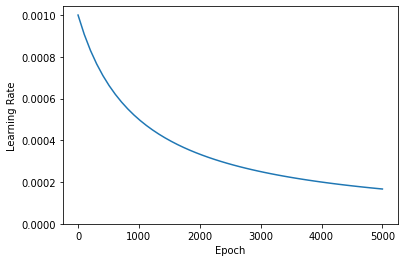

In [29]:
step = np.linspace(0,100000)
lr = lr_schedule(step)
plt.figure(figsize = (6,4))
plt.plot(step/STEPS_PER_EPOCH, lr)
plt.ylim([0,max(plt.ylim())])
plt.xlabel('Epoch')
_ = plt.ylabel('Learning Rate')

In [30]:
#lrs = 1e-4 * (10 ** (tf.range(40)/20))
#plt.figure(figsize=(6,4))
#plt.semilogx(lrs, history.history['loss'])
#plt.xlabel("Learning Rate")
#plt.ylabel("Loss")
#plt.title("Learning Rate vs Loss")

### Settings for automation

In [31]:
def get_callbacks(name):
  return [
    tfdocs.modeling.EpochDots(),
    tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=200),
    tf.keras.callbacks.TensorBoard(os.path.join(logdir,name)),
  ]

In [32]:
def compile_and_fit(model, name, loss=None, optimizer=None, metrics = None, max_epochs=10000):
  if optimizer is None:
    optimizer = get_optimizer()

  if loss is None:
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
  if metrics is None:
    metrics = ['accuracy']
  model.compile(
      optimizer=optimizer,
      loss=loss,
      metrics=metrics
  )

  model.summary()

  history = model.fit(
    X_train,
    y_train,
    steps_per_epoch = STEPS_PER_EPOCH,
    epochs=max_epochs,
    validation_split=0.1,
    #validation_data=[X_test, y_test],
    callbacks=get_callbacks(name),
    verbose=0)
  return history

### Models

In [33]:
size_histories = {}

#### Model 1

Simple model with 3 layers

In [34]:
model_1 = tf.keras.Sequential([
    layers.Dense(4, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(41)
])

In [35]:
size_histories['model1'] = compile_and_fit(
    model_1, 
    'models/model1', 
    loss=tf.keras.losses.SparseCategoricalCrossentropy()
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 4)                 532       
                                                                 
 dense_1 (Dense)             (None, 41)                205       
                                                                 
Total params: 737
Trainable params: 737
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.0528,  loss:9.0343,  val_accuracy:0.0355,  val_loss:7.9728,  
....................................................................................................
Epoch: 100, accuracy:0.3659,  loss:2.8343,  val_accuracy:0.3832,  val_loss:2.7463,  
....................................................................................................
Epoch: 200, accuracy:0.2998,  loss:2.9671,  val_accuracy:0.3223,  val_loss:2.8936, 

#### Model 2

In [36]:


model = tf.keras.Sequential([
    tf.keras.layers.Dense(4, activation=tf.keras.activations.relu),
    tf.keras.layers.Dense(4, activation=tf.keras.activations.relu),
    tf.keras.layers.Dense(41, activation=tf.keras.activations.softmax)
])

model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                optimizer = tf.keras.optimizers.Adam(),
                #metrics=['MultiClassConfusionMatrixPlot'])
                metrics=["accuracy"])

scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10 **(epoch/20))

history = model.fit(X_train, y_train, epochs=40, callbacks=[scheduler])

Epoch 1/40
123/123 [==============================] - 1s 2ms/step - loss: 3.7144 - accuracy: 0.0333 - lr: 1.0000e-04
Epoch 2/40
123/123 [==============================] - 0s 2ms/step - loss: 3.7080 - accuracy: 0.0630 - lr: 1.1220e-04
Epoch 3/40
123/123 [==============================] - 0s 2ms/step - loss: 3.7005 - accuracy: 0.0689 - lr: 1.2589e-04
Epoch 4/40
123/123 [==============================] - 0s 2ms/step - loss: 3.6905 - accuracy: 0.0655 - lr: 1.4125e-04
Epoch 5/40
123/123 [==============================] - 0s 2ms/step - loss: 3.6754 - accuracy: 0.0716 - lr: 1.5849e-04
Epoch 6/40
123/123 [==============================] - 0s 2ms/step - loss: 3.6506 - accuracy: 0.0577 - lr: 1.7783e-04
Epoch 7/40
123/123 [==============================] - 0s 2ms/step - loss: 3.6069 - accuracy: 0.0633 - lr: 1.9953e-04
Epoch 8/40
123/123 [==============================] - 0s 2ms/step - loss: 3.5369 - accuracy: 0.0838 - lr: 2.2387e-04
Epoch 9/40
123/123 [==============================] - 0s 2ms/ste

#### Model 3

#### Model 4

#### Model 5

### 3. Evaluate Model

#### Evaluate with test data

In [37]:
loss, acc = model_1.evaluate(X_test, y_test)
print(f"Model Loss (Test Set) : {loss}")
print(f"Model Accuracy (Test Set): {acc}")

31/31 [==============================] - 0s 1ms/step - loss: 2.9701 - accuracy: 0.2917
Model Loss (Test Set) : 2.970146417617798
Model Accuracy (Test Set): 0.2916666567325592


#### Evaluate with unseen data

In [38]:
loss, acc = model.evaluate(X_unseen, y_unseen)
print(f"Model Loss (Unseen Data Set) : {loss}")
print(f"Model Accuracy (Unseen Data Set): {acc}")

2/2 [==============================] - 0s 7ms/step - loss: 0.2755 - accuracy: 0.9762
Model Loss (Unseen Data Set) : 0.2755151689052582
Model Accuracy (Unseen Data Set): 0.976190447807312


## 3. Testing

#### Test Set

In [39]:
### Test set
predictions = model.predict(X_test)
predictions[0]

31/31 [==============================] - 0s 1ms/step


array([1.87355596e-28, 0.00000000e+00, 1.12177086e-05, 0.00000000e+00,
       0.00000000e+00, 8.94049706e-33, 0.00000000e+00, 0.00000000e+00,
       1.56602437e-35, 0.00000000e+00, 0.00000000e+00, 1.20466535e-08,
       0.00000000e+00, 0.00000000e+00, 1.37545760e-06, 0.00000000e+00,
       4.34752330e-02, 4.33702315e-24, 0.00000000e+00, 1.55197881e-18,
       8.27619111e-16, 1.10837941e-33, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 8.58278759e-03,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 4.08066152e-14,
       0.00000000e+00, 0.00000000e+00, 1.23992190e-16, 9.47929323e-01,
       8.28681433e-29], dtype=float32)

In [40]:
result = class_names[tf.argmax(predictions, axis=1)]


#### Unseen Test Data

In [41]:
prediction_unseen_data = model.predict(X_unseen)
prediction_unseen_data

2/2 [==============================] - 0s 5ms/step


array([[1.3315416e-07, 0.0000000e+00, 1.5034732e-17, ..., 0.0000000e+00,
        1.2599960e-38, 0.0000000e+00],
       [5.9846997e-25, 0.0000000e+00, 1.2424171e-25, ..., 2.4755610e-12,
        9.5179368e-29, 7.1482333e-08],
       [2.5188620e-14, 0.0000000e+00, 4.6044679e-05, ..., 1.3000131e-04,
        1.2744000e-03, 1.8888976e-08],
       ...,
       [7.3252084e-20, 0.0000000e+00, 1.4860669e-06, ..., 3.9428767e-34,
        7.1116526e-09, 0.0000000e+00],
       [8.2774137e-17, 8.9279941e-16, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [1.6280363e-07, 0.0000000e+00, 5.6451677e-07, ..., 1.7108356e-31,
        1.3561726e-17, 1.0487157e-34]], dtype=float32)

In [42]:
result = class_names[tf.argmax(prediction_unseen_data, axis=1)]
result

array(['Fungal infection', 'Allergy', 'GERD', 'Chronic cholestasis',
       'Drug Reaction', 'Peptic ulcer diseae', 'AIDS', 'Diabetes ',
       'Gastroenteritis', 'Bronchial Asthma', 'Hypertension ', 'Migraine',
       'Cervical spondylosis', 'Paralysis (brain hemorrhage)', 'Jaundice',
       'Malaria', 'Chicken pox', 'Dengue', 'Typhoid', 'hepatitis A',
       'Hepatitis B', 'Hepatitis C', 'Hepatitis D', 'Hepatitis E',
       'Alcoholic hepatitis', 'Tuberculosis', 'Common Cold', 'Pneumonia',
       'Dimorphic hemmorhoids(piles)', 'Heart attack', 'Varicose veins',
       'Hypothyroidism', 'Hyperthyroidism', 'Hypoglycemia',
       'Osteoarthristis', 'Arthritis',
       '(vertigo) Paroymsal  Positional Vertigo', 'Acne',
       'Urinary tract infection', 'Psoriasis', 'Impetigo', 'Diabetes '],
      dtype=object)

### Correlation Matrix

In [43]:
#plt.figure(figsize=(25,12))

#sns.heatmap(disease_training.corr().abs(), annot=True)
